In [1]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.1.0
Hub version: 0.7.0
GPU is available


# Set up the Colab environment with the train and test zip files

In [3]:
import os
os.getcwd()

'/kaggle/working'

In [4]:
input_shape = [128, 128, 3]

In [5]:
%cd /kaggle/input

/kaggle/input


In [6]:
%cd ..

/kaggle


In [7]:
ls

input/  lib/  working/


# Create the train, validation, and test datasets

In [8]:
import pandas as pd
# View the csv file containing the labels for the training images
train_labels = pd.read_csv("/kaggle/input/ICH_coding_challenge_train.csv")
train_labels.head()

,Unnamed: 0,ID,epidural,intraparenchymal,subarachnoid
0,0,train_0,1,0,1
1,1,train_1,1,0,0
2,2,train_2,1,0,1
3,3,train_3,1,0,1
4,4,train_4,1,0,0


In [9]:
train_labels = train_labels.drop(['Unnamed: 0'],axis=1)

In [10]:
train_labels

,ID,epidural,intraparenchymal,subarachnoid
0,train_0,1,0,1
1,train_1,1,0,0
2,train_2,1,0,1
3,train_3,1,0,1
4,train_4,1,0,0
...,...,...,...,...
8537,train_8588,0,0,0
8538,train_8589,0,0,0
8539,train_8590,0,0,0
8540,train_8591,0,0,0


In [11]:
train_labels.shape  

(8542, 4)

In [12]:
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import glob
import numpy as np

X = []

for i in tqdm(range(train_labels.shape[0])):
    path = "/kaggle/input/train_images/train_images/" + train_labels['ID'][i] + '.png'
    img = image.load_img(path, target_size=(input_shape))
    img = image.img_to_array(img)
#     img = img/255.0
    X.append(img)

X = np.array(X)

100%|██████████| 8542/8542 [00:18<00:00, 465.08it/s]


In [13]:
os.getcwd()

'/kaggle'

In [14]:
y = train_labels.drop(['ID'], axis = 1)
y = y.to_numpy()
y.shape

(8542, 3)

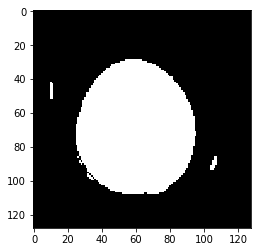

In [15]:
import matplotlib.pyplot as plt
plt.imshow(X[1])

In [16]:
!pip install iterative-stratification

In [17]:
######################################
# Multi-Label Stratified Shuffle Split
######################################

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.15, random_state=0)

for train_index, val_index in msss.split(X, y):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

TRAIN: [   0    1    2 ... 8538 8540 8541] VAL: [  13   21   24 ... 8529 8530 8539]
TRAIN: [   0    1    2 ... 8539 8540 8541] VAL: [  11   21   29 ... 8505 8511 8524]
TRAIN: [   0    3    4 ... 8539 8540 8541] VAL: [   1    2    8 ... 8500 8509 8529]


In [18]:
######################################
# Repeated Multi label Stratified KFold
######################################

# from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold

# rmskf = RepeatedMultilabelStratifiedKFold(n_splits=3, n_repeats=2, random_state=0)

# for train_index, val_index in rmskf.split(X, y):
#    print("TRAIN:", train_index, "VAL:", val_index)
#    X_train, X_val = X[train_index], X[val_index]
#    y_train, y_val = y[train_index], y[val_index]

In [19]:
######################################
# Multi label Stratified KFold
######################################

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# mskf = MultilabelStratifiedKFold(n_splits=3, random_state=0)

# for train_index, val_index in mskf.split(X, y):
#    print("TRAIN:", train_index, "VAL:", val_index)
#    X_train, X_val = X[train_index], X[val_index]
#    y_train, y_val = y[train_index], y[val_index]

In [20]:
#########################################################
####### Standard train-test-split with validation #######
########## set of 15% and the data shuffled #############
#########################################################

# X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0, test_size = 0.15, shuffle = True)

In [21]:
print('Train data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Train data shape:  (7260, 128, 128, 3)
Training labels shape:  (7260, 3)
Validation data shape:  (1282, 128, 128, 3)
Validation labels shape:  (1282, 3)


# Model Selection and Data Augmentation

In [22]:
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, AveragePooling2D, Conv2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import ResNet50

In [23]:
############################
#### Data Augmentation #####
############################

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16) # batch size = 16

val_generator = val_datagen.flow(X_val, y_val,batch_size=16) # batch size = 16

In [24]:
#############################
####### Resnet 50 ###########
#############################

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(
#     include_top=False, weights='imagenet', input_shape=input_shape)

# frozen_layers, trainable_layers = [], []
# for layer in resnet50_feature_extractor.layers:
#     if isinstance(layer, tf.keras.layers.Conv2D):
#         layer.trainable = False
#         frozen_layers.append(layer.name)
#     else:
#         if len(layer.trainable_weights) > 0:
#             # We list as "trainable" only the layers with trainable parameters.
#             trainable_layers.append(layer.name)

In [25]:
# resnet50_feature_extractor.summary()

In [26]:
# log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
# log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
# log_end_format = '\033[0m'

# # Logging the lists of frozen/trainable layers:
# print("{2}Layers we froze:{4} {0} ({3}total = {1}{4}).".format(
#     frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))

# print("\n{2}Layers which will be fine-tuned:{4} {0} ({3}total = {1}{4}).".format(
#     trainable_layers, len(trainable_layers), log_begin_blue, log_begin_bold, log_end_format))

In [27]:
##########################
###### Inception V3 ######
##########################

num_classes = 3

model = tf.keras.Sequential([
                         hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", 
                         output_shape=[2048],
                         trainable=False),  # Can be True, see below.
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Dropout(rate = 0.5), # change to 0.5 next
                        #  tf.keras.layers.GlobalAveragePooling2D(data_format = 'channels_last'),
                         tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
                        ])
model.build([None, 128, 128, 3])  # Batch input shape.

#########################
###### ResNetV2 50 ######
#########################

# model = tf.keras.Sequential([
#                          hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", 
#                          trainable=False),  # Can be True, see below.
#                          tf.keras.layers.BatchNormalization(),
#                          tf.keras.layers.Dropout(rate = 0.2),
#                         #  tf.keras.layers.GlobalAveragePooling2D(data_format = 'channels_last'),
#                          tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
#                         ])
# model.build([None, 128, 128, 3])  # Batch input shape.

# features = resnet50_feature_extractor.output
# xx = BatchNormalization()(features)
# yy = Dropout(0.2)(xx)
# avg_pool = GlobalAveragePooling2D(data_format='channels_last')(yy)
# predictions = Dense(num_classes, activation='sigmoid')(avg_pool)

# resnet50_freeze = Model(resnet50_feature_extractor.input, predictions)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
batch_normalization (BatchNo multiple                  8192      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  6147      
Total params: 21,817,123
Trainable params: 10,243
Non-trainable params: 21,806,880
_________________________________________________________________


# Model Training

In [29]:
num_epochs = 100

# model = resnet50_freeze

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.BinaryCrossentropy()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_freeze = model.fit(train_generator,
                           epochs = num_epochs, 
                           validation_data = val_generator,
                           callbacks = [callback]
                           )

Train for 454 steps, validate for 81 steps
Epoch 1/100
454/454 [==============================] - 41s 90ms/step - loss: 1.0186 - acc: 0.5126 - recall: 0.4974 - precision: 0.2592 - binary_crossentropy: 1.0180 - val_loss: 0.8394 - val_acc: 0.5200 - val_recall: 0.5503 - val_precision: 0.2757 - val_binary_crossentropy: 0.8416
Epoch 2/100
454/454 [==============================] - 30s 65ms/step - loss: 0.9309 - acc: 0.5435 - recall: 0.5251 - precision: 0.2835 - binary_crossentropy: 0.9302 - val_loss: 0.7723 - val_acc: 0.5666 - val_recall: 0.5708 - val_precision: 0.3080 - val_binary_crossentropy: 0.7747
Epoch 3/100
454/454 [==============================] - 30s 67ms/step - loss: 0.8746 - acc: 0.5665 - recall: 0.5380 - precision: 0.3010 - binary_crossentropy: 0.8739 - val_loss: 0.7136 - val_acc: 0.6071 - val_recall: 0.5524 - val_precision: 0.3335 - val_binary_crossentropy: 0.7161
Epoch 4/100
454/454 [==============================] - 30s 66ms/step - loss: 0.8253 - acc: 0.5926 - recall: 0.5534

Epoch 30/100
454/454 [==============================] - 29s 65ms/step - loss: 0.5234 - acc: 0.7619 - recall: 0.4709 - precision: 0.5340 - binary_crossentropy: 0.5229 - val_loss: 0.4318 - val_acc: 0.7894 - val_recall: 0.4743 - val_precision: 0.6079 - val_binary_crossentropy: 0.4345
Epoch 31/100
454/454 [==============================] - 30s 66ms/step - loss: 0.5248 - acc: 0.7631 - recall: 0.4740 - precision: 0.5367 - binary_crossentropy: 0.5242 - val_loss: 0.4312 - val_acc: 0.7920 - val_recall: 0.4641 - val_precision: 0.6192 - val_binary_crossentropy: 0.4340
Epoch 32/100
454/454 [==============================] - 30s 65ms/step - loss: 0.5253 - acc: 0.7613 - recall: 0.4637 - precision: 0.5332 - binary_crossentropy: 0.5248 - val_loss: 0.4295 - val_acc: 0.7925 - val_recall: 0.4754 - val_precision: 0.6173 - val_binary_crossentropy: 0.4322
Epoch 33/100
454/454 [==============================] - 30s 66ms/step - loss: 0.5226 - acc: 0.7607 - recall: 0.4620 - precision: 0.5317 - binary_crossentr

454/454 [==============================] - 29s 64ms/step - loss: 0.4838 - acc: 0.7755 - recall: 0.4834 - precision: 0.5667 - binary_crossentropy: 0.4833 - val_loss: 0.4118 - val_acc: 0.8060 - val_recall: 0.4867 - val_precision: 0.6583 - val_binary_crossentropy: 0.4146
Epoch 60/100
454/454 [==============================] - 30s 66ms/step - loss: 0.4848 - acc: 0.7728 - recall: 0.4771 - precision: 0.5606 - binary_crossentropy: 0.4843 - val_loss: 0.4115 - val_acc: 0.8040 - val_recall: 0.4795 - val_precision: 0.6541 - val_binary_crossentropy: 0.4143
Epoch 61/100
454/454 [==============================] - 29s 64ms/step - loss: 0.4828 - acc: 0.7786 - recall: 0.4914 - precision: 0.5734 - binary_crossentropy: 0.4822 - val_loss: 0.4113 - val_acc: 0.8058 - val_recall: 0.4877 - val_precision: 0.6570 - val_binary_crossentropy: 0.4141
Epoch 62/100
454/454 [==============================] - 30s 66ms/step - loss: 0.4738 - acc: 0.7788 - recall: 0.4867 - precision: 0.5749 - binary_crossentropy: 0.4733 -

454/454 [==============================] - 30s 66ms/step - loss: 0.4569 - acc: 0.7857 - recall: 0.5017 - precision: 0.5906 - binary_crossentropy: 0.4564 - val_loss: 0.4016 - val_acc: 0.8123 - val_recall: 0.4949 - val_precision: 0.6770 - val_binary_crossentropy: 0.4044
Epoch 89/100
454/454 [==============================] - 29s 64ms/step - loss: 0.4591 - acc: 0.7801 - recall: 0.4820 - precision: 0.5793 - binary_crossentropy: 0.4586 - val_loss: 0.4012 - val_acc: 0.8136 - val_recall: 0.4949 - val_precision: 0.6818 - val_binary_crossentropy: 0.4039
Epoch 90/100
454/454 [==============================] - 30s 66ms/step - loss: 0.4590 - acc: 0.7842 - recall: 0.4974 - precision: 0.5875 - binary_crossentropy: 0.4586 - val_loss: 0.4003 - val_acc: 0.8149 - val_recall: 0.5185 - val_precision: 0.6751 - val_binary_crossentropy: 0.4029
Epoch 91/100
454/454 [==============================] - 29s 64ms/step - loss: 0.4549 - acc: 0.7813 - recall: 0.4948 - precision: 0.5801 - binary_crossentropy: 0.4545 -

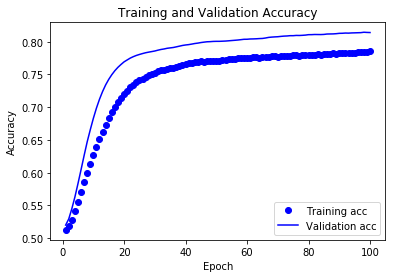

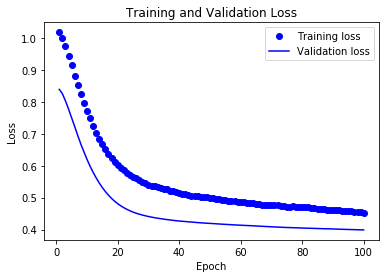

In [30]:
####################################
# # Plot the Performance Results # #
####################################

def smooth_curve(points,factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot the loss and accuracy of the model over the train/val datasets during training
acc = history_freeze.history['acc']
val_acc = history_freeze.history['val_acc']
loss = history_freeze.history['loss']
val_loss = history_freeze.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [31]:
best_train_acc = max(history_freeze.history['acc']) * 100
best_val_acc = max(history_freeze.history['val_acc']) * 100

print('Best train acc:  {:2.2f}%'.format(best_train_acc))
print('Best val acc: {:2.2f}%'.format(best_val_acc))

Best train acc:  78.72%
Best val acc: 81.70%


In [32]:
%cd /kaggle/working

/kaggle/working


In [33]:
os.getcwd()

'/kaggle/working'

In [34]:
!mkdir Models
%cd Models
model.save('ICH_Net8.h5')

/kaggle/working/Models


# Model Testing and Exporting Predictions

In [35]:
%cd /kaggle/input/test_images/test_images

/kaggle/input/test_images/test_images


In [36]:
import re
testimgs =  os.listdir("/kaggle/input/test_images/test_images")
testimgs.sort(key=lambda f: int(re.sub('\D', '', f)))
testimgs

['test_0.png',
 'test_1.png',
 'test_2.png',
 'test_3.png',
 'test_5.png',
 'test_6.png',
 'test_7.png',
 'test_8.png',
 'test_9.png',
 'test_10.png',
 'test_11.png',
 'test_12.png',
 'test_13.png',
 'test_14.png',
 'test_15.png',
 'test_16.png',
 'test_17.png',
 'test_18.png',
 'test_19.png',
 'test_20.png',
 'test_21.png',
 'test_22.png',
 'test_23.png',
 'test_24.png',
 'test_25.png',
 'test_26.png',
 'test_27.png',
 'test_28.png',
 'test_29.png',
 'test_30.png',
 'test_31.png',
 'test_32.png',
 'test_33.png',
 'test_34.png',
 'test_35.png',
 'test_36.png',
 'test_37.png',
 'test_38.png',
 'test_39.png',
 'test_40.png',
 'test_41.png',
 'test_42.png',
 'test_43.png',
 'test_44.png',
 'test_45.png',
 'test_46.png',
 'test_47.png',
 'test_48.png',
 'test_49.png',
 'test_50.png',
 'test_51.png',
 'test_52.png',
 'test_53.png',
 'test_54.png',
 'test_55.png',
 'test_56.png',
 'test_57.png',
 'test_58.png',
 'test_59.png',
 'test_60.png',
 'test_61.png',
 'test_62.png',
 'test_63.png',
 

In [37]:
# list of probabiliy predictions on test set
probabilities = []

# list of binary predictions on test set
binaries = []

# Get the names of the test images to put into a csv file with predictions 
test_images = []

for testfiles in testimgs:
  # print(testfiles)
    testfiles_noext = os.path.splitext(testfiles)[0]
    test_images.append(testfiles_noext)

    testimg = image.load_img(testfiles,target_size = (128, 128, 3))
    testimg = image.img_to_array(testimg)
    testimg = testimg/255.0
    testimg = testimg.reshape(1, 128, 128, 3)
    t_prob = model.predict(testimg)

    probabilities.append(t_prob[0])

    empty_list = []

    # 50% threshold since each prediction is just a binary classification problem
    # for each class
    for t in range(len(t_prob[0])):
        if t_prob[0][t] < 0.5:
            empty_list.append(np.int(0))
        elif t_prob[0][t] > 0.5:
            empty_list.append(np.int(1))
    empty_list = np.array(empty_list)

    binaries.append(empty_list)

In [38]:
len(test_images)

4019

In [39]:
os.getcwd()

'/kaggle/input/test_images/test_images'

In [40]:
len(probabilities)

4019

In [41]:
probabilities[0:10]

[array([0.00528987, 0.55265063, 0.7624482 ], dtype=float32),
 array([0.02358457, 0.18310502, 0.65192413], dtype=float32),
 array([0.1733772 , 0.16024685, 0.4509953 ], dtype=float32),
 array([0.06257047, 0.36580175, 0.45917925], dtype=float32),
 array([0.01803357, 0.22967903, 0.55394155], dtype=float32),
 array([0.01262616, 0.5095062 , 0.5126876 ], dtype=float32),
 array([0.00923141, 0.47054833, 0.2755644 ], dtype=float32),
 array([0.04796678, 0.6948748 , 0.4208331 ], dtype=float32),
 array([0.03165352, 0.47971645, 0.39335558], dtype=float32),
 array([0.06603528, 0.24159268, 0.30691484], dtype=float32)]

In [42]:
len(binaries)

4019

In [43]:
binaries[0:10]

[array([0, 1, 1]),
 array([0, 0, 1]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 1]),
 array([0, 1, 1]),
 array([0, 0, 0]),
 array([0, 1, 0]),
 array([0, 0, 0]),
 array([0, 0, 0])]

In [44]:
probabilities = np.array(probabilities)
binaries = np.array(binaries)

In [45]:
probabilities.shape

(4019, 3)

In [46]:
binaries.shape

(4019, 3)

In [47]:
print(type(probabilities))
print(type(binaries))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [48]:
%cd /kaggle/working

/kaggle/working


In [49]:
%mkdir Predictions
%cd Predictions

/kaggle/working/Predictions


In [50]:
test_images = np.array(test_images)

In [51]:
df = pd.DataFrame(data = probabilities, columns = ['epidural', 'intraparenchymal',	'subarachnoid'])
df.insert(0,"ID",test_images)
df

,ID,epidural,intraparenchymal,subarachnoid
0,test_0,0.005290,0.552651,0.762448
1,test_1,0.023585,0.183105,0.651924
2,test_2,0.173377,0.160247,0.450995
3,test_3,0.062570,0.365802,0.459179
4,test_5,0.018034,0.229679,0.553942
...,...,...,...,...
4014,test_4033,0.009588,0.100188,0.162600
4015,test_4034,0.071908,0.292738,0.154309
4016,test_4035,0.018323,0.040089,0.097706
4017,test_4036,0.002765,0.150839,0.222831


In [52]:
df2 = pd.DataFrame(data = binaries, columns = ['epidural', 'intraparenchymal',	'subarachnoid'])
df2.insert(0,"ID",test_images)
df2

,ID,epidural,intraparenchymal,subarachnoid
0,test_0,0,1,1
1,test_1,0,0,1
2,test_2,0,0,0
3,test_3,0,0,0
4,test_5,0,0,1
...,...,...,...,...
4014,test_4033,0,0,0
4015,test_4034,0,0,0
4016,test_4035,0,0,0
4017,test_4036,0,0,0


In [53]:
df.to_csv('/kaggle/working/Predictions/probabilities.csv',index=True)
df2.to_csv('/kaggle/working/Predictions/binary_preds.csv',index=True)

In [54]:
%pwd

'/kaggle/working/Predictions'